In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
df = pd.read_csv('data/DISB34.SA.csv')
df = df.dropna()
df.shape

(1335, 7)

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,175.470001,175.470001,175.470001,175.470001,175.470001,0
1,2014-01-03,175.470001,175.470001,175.470001,175.470001,175.470001,0
2,2014-01-06,175.470001,175.470001,175.470001,175.470001,175.470001,0
3,2014-01-07,180.100006,180.100006,180.100006,182.070007,182.070007,200
4,2014-01-08,180.410004,180.410004,180.410004,179.710007,179.710007,6400


In [4]:
df['Date'] = pd.to_datetime(df['Date'])

train = df.iloc[:df.shape[0] - 90]
test = df.iloc[df.shape[0] - 90:]

In [5]:
# Número de amostras utilizadas para previsão, consideradas como memória recente.
timesteps = 10 
# Colunas que serão utlizadas na previsão do target.
features = ['Close']
target = 'Close'

### Normalização dos dados

In [6]:
# Normalizador para transformar os dados do DataFrame antes da previsão.

scaler_features = MinMaxScaler(feature_range=(0,1))
train_norm = pd.DataFrame(
    data= scaler_features.fit_transform(train[features]),
    columns= features
)

test_norm = pd.DataFrame(
    data= scaler_features.transform(test[features]),
    columns= features
)

# Este normalizador poderia ser utilizado para inverter a transformação 
# do target, mas como a previsão é apenas de uma coluna, um normalizador 
# do target será criado.

In [7]:
# Normalizador que será utilizado para inverter a transformação 
# do target depois da previsão.

scaler_target = MinMaxScaler(feature_range=(0,1))
scaler_target.fit(train.iloc[:, 4:5])

MinMaxScaler(copy=True, feature_range=(0, 1))

### Transformação dos dados para RNN

In [8]:
def transformar_dados_para_RNN(df, timesteps, colunas, target, append_before=None):
    '''
        df : DataFrame que será tansformado.
        timesteps : Número de amostras que serão utilizadas. Amostras anteriores à cada previsão.
        colunas : Nomes das colunas do DataFrame que serão utilizadas.
        target : Nome do coluna que será prevista.
        append_before : DataFrame que será utilizado para extrair N amostras anteriores ao 'df'.
    '''
    
    if append_before is not None:
        df_append = append_before
        n_amos = df_append.shape[0] - timesteps
        df = pd.concat((df_append.iloc[n_amos:], df), axis=0)
    
    previsores = []
    valores_target = []

    for i in range (timesteps, df.shape[0]):
        previsores.append(np.matrix(df.iloc[i-timesteps:i][colunas]))
        valores_target.append(df[target].iloc[i])
        
    return np.array(previsores), np.array(valores_target)

In [9]:
x_train, y_train = transformar_dados_para_RNN(train_norm, timesteps, features, target)
x_test, y_test = transformar_dados_para_RNN(test_norm, timesteps, features, target, append_before=train_norm)

### Criação do modelo de RNN

In [10]:
model = Sequential()

model.add(LSTM(15, activation='linear', return_sequences=True, input_shape=(timesteps, len(features)) ))
model.add(Dropout(0.3))
model.add(LSTM(30, activation='linear', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(20, activation='linear', return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.compile(
    optimizer='rmsprop',
    loss='msle',
    metrics=['mae']
)

In [12]:
model.fit(x_train, y_train, batch_size=20, epochs=150)

Instructions for updating:
Use tf.cast instead.
Epoch 1/150
1235/1235 [==============================] - 3s 3ms/step - loss: 0.0127 - mean_absolute_error: 0.1044
Epoch 2/150
1235/1235 [==============================] - 1s 919us/step - loss: 0.0013 - mean_absolute_error: 0.0432
Epoch 3/150
1235/1235 [==============================] - 1s 932us/step - loss: 0.0012 - mean_absolute_error: 0.0423
Epoch 4/150
1235/1235 [==============================] - 1s 954us/step - loss: 0.0011 - mean_absolute_error: 0.0396
Epoch 5/150
1235/1235 [==============================] - 1s 947us/step - loss: 9.7187e-04 - mean_absolute_error: 0.0380
Epoch 6/150
1235/1235 [==============================] - 1s 948us/step - loss: 9.3675e-04 - mean_absolute_error: 0.0367
Epoch 7/150
1235/1235 [==============================] - 1s 971us/step - loss: 8.8966e-04 - mean_absolute_error: 0.0363
Epoch 8/150
1235/1235 [==============================] - 1s 949us/step - loss: 8.1331e-04 - mean_absolute_error: 0.0348
Epoch 9/15

1235/1235 [==============================] - 1s 915us/step - loss: 3.2414e-04 - mean_absolute_error: 0.0201
Epoch 134/150
1235/1235 [==============================] - 1s 901us/step - loss: 3.3371e-04 - mean_absolute_error: 0.0212
Epoch 135/150
1235/1235 [==============================] - 1s 892us/step - loss: 3.2028e-04 - mean_absolute_error: 0.0204
Epoch 136/150
1235/1235 [==============================] - 1s 916us/step - loss: 2.9688e-04 - mean_absolute_error: 0.0197
Epoch 137/150
1235/1235 [==============================] - 1s 903us/step - loss: 2.9726e-04 - mean_absolute_error: 0.0200
Epoch 138/150
1235/1235 [==============================] - 1s 912us/step - loss: 3.0894e-04 - mean_absolute_error: 0.0201
Epoch 139/150
1235/1235 [==============================] - 1s 925us/step - loss: 3.0552e-04 - mean_absolute_error: 0.0201
Epoch 140/150
1235/1235 [==============================] - 1s 912us/step - loss: 3.0601e-04 - mean_absolute_error: 0.0196
Epoch 141/150
1235/1235 [=============

In [13]:
pred = model.predict(x_test)

In [14]:
pred = scaler_target.inverse_transform(pred)

In [15]:
metrics.mean_absolute_error(test[target], pred)

19.514720337760416

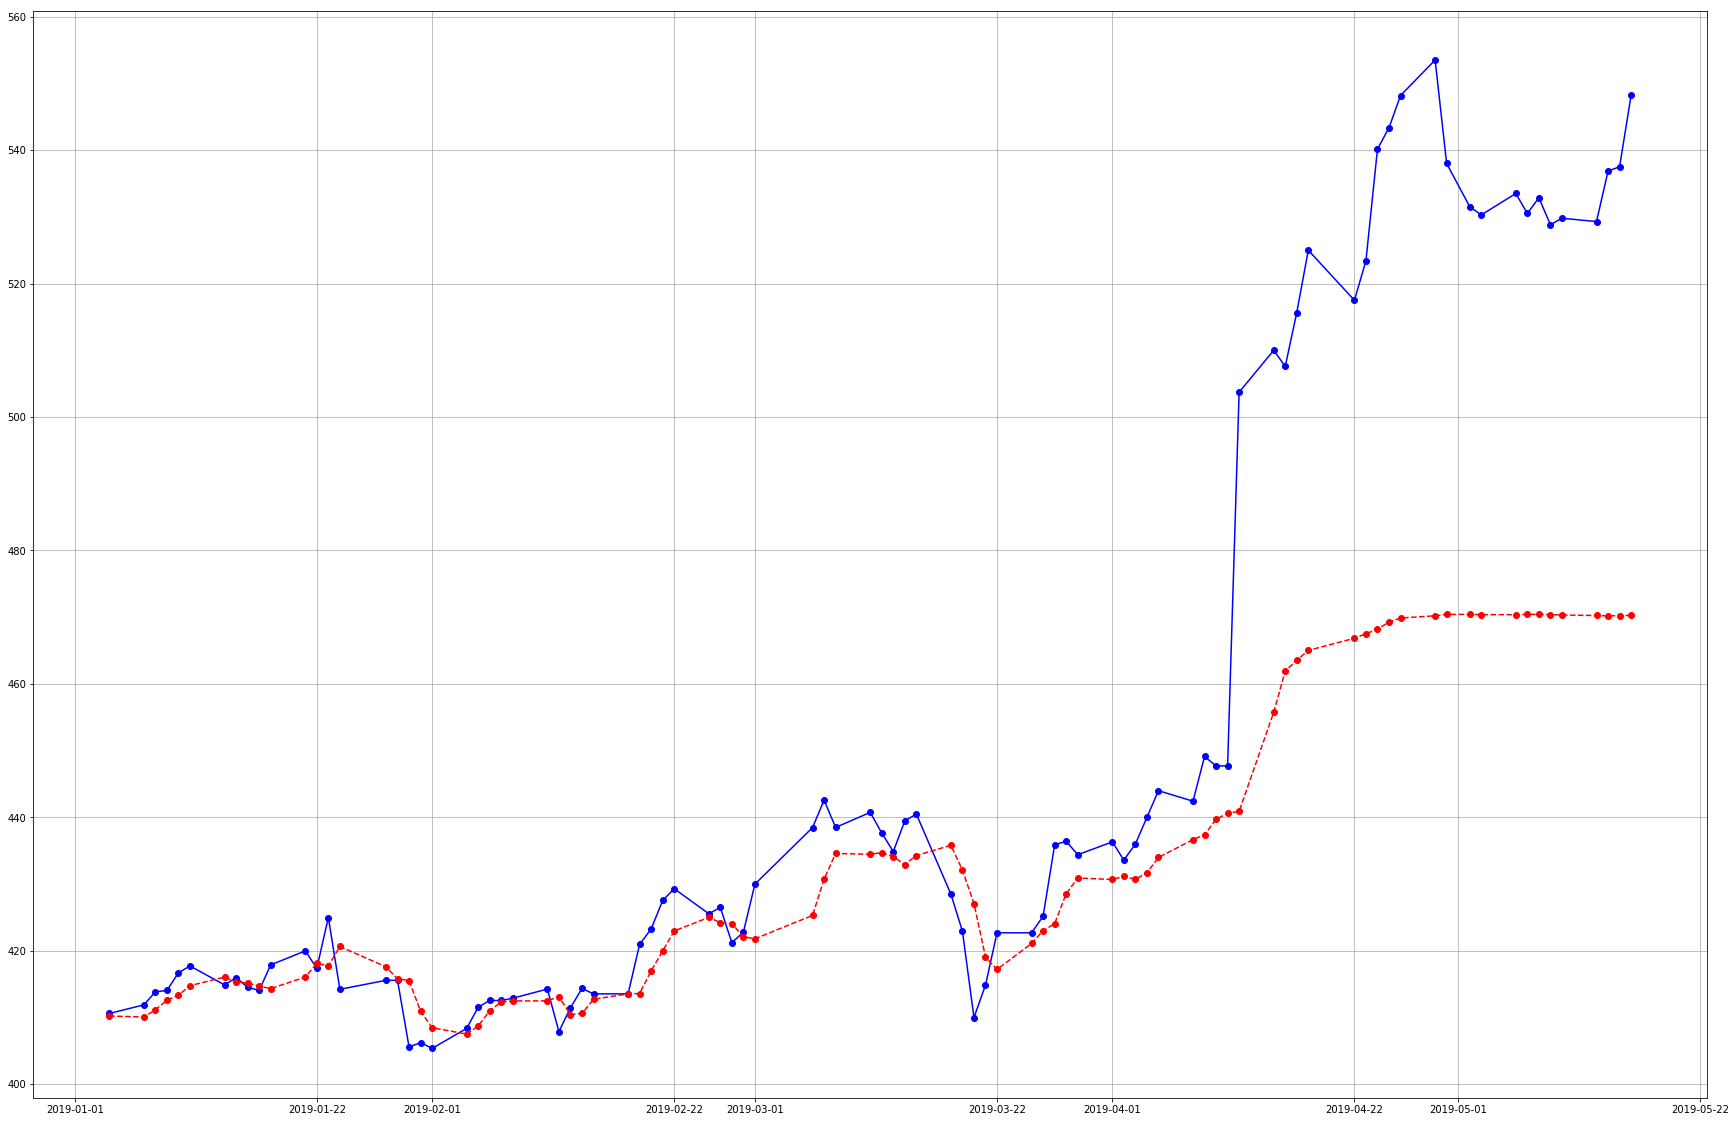

In [17]:
plt.figure(figsize=(30, 20))
plt.plot(test.Date, test.Close, color='blue', label='Preço real', linestyle='-', marker='o')
plt.plot(test.Date, pred, color='red', label='Preço previsto', linestyle='--', marker='o')
plt.grid(True)

In [174]:
y_test

array([94755., 92875., 93083., 94333., 93285., 94578., 94588., 95923.,
       95045., 96552., 96236., 96188., 96353., 95528., 96008., 95009.,
       94389., 95597., 94808., 94258.])

In [178]:
pd.to_datetime(test['Date'])

479   2019-04-11
480   2019-04-12
481   2019-04-15
482   2019-04-16
483   2019-04-17
484   2019-04-18
485   2019-04-22
486   2019-04-23
487   2019-04-24
488   2019-04-25
489   2019-04-26
490   2019-04-29
491   2019-04-30
492   2019-05-02
493   2019-05-03
494   2019-05-06
495   2019-05-07
496   2019-05-08
497   2019-05-09
498   2019-05-10
Name: Date, dtype: datetime64[ns]